In [193]:
# import torch
# # check cuda
# # !nvcc -V
# # !nvidia-smi
# print(torch.cuda.is_available())
# print(torch.__version__)

In [194]:
# import library
import time
import copy
import numpy as np
import pandas as pd
import chainer
import chainer.functions as F
import chainer.links as L
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
import random
import torch
import matplotlib.pyplot as plt
init_notebook_mode(connected=True)


In [195]:
data = pd.read_csv('data_4953_date.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
print(data.index.min(), data.index.max())
data.head()

2017-01-03 00:00:00 2023-05-31 00:00:00


,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover,dividend_yield,PER,...,ShortSaleLimit,ShortSaleSell,ShortSaleTodayBalance,ShortSaleYesterdayBalance,ForeignInvestmentRemainingShares,ForeignInvestmentShares,ForeignInvestmentRemainRatio,ForeignInvestmentSharesRatio,ForeignInvestmentUpperLimitRatio,ChineseInvestmentUpperLimitRatio
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,23000.0,504700.0,21.90,22.05,21.75,21.75,-0.35,16.0,4.71,0.0,...,10969.0,0.0,0.0,0.0,40592548,3285774,92.51,7.48,100.0,100.0
2017-01-04,28000.0,618400.0,21.65,22.50,21.65,22.10,0.35,17.0,4.64,0.0,...,10969.0,0.0,0.0,0.0,40592548,3285774,92.51,7.48,100.0,100.0
2017-01-05,42000.0,923150.0,22.10,22.10,21.90,22.10,0.00,28.0,4.64,0.0,...,10969.0,0.0,0.0,0.0,40592548,3285774,92.51,7.48,100.0,100.0
2017-01-06,47000.0,1025750.0,21.95,21.95,21.65,21.75,-0.35,27.0,4.71,0.0,...,10969.0,0.0,0.0,0.0,40590548,3287774,92.50,7.49,100.0,100.0
2017-01-09,14000.0,304900.0,21.80,21.85,21.70,21.80,0.05,11.0,4.70,0.0,...,10969.0,0.0,0.0,0.0,40592548,3285774,92.51,7.48,100.0,100.0


In [196]:
date_split = '2023-01-01'
train = data[:date_split]
test = data[date_split:]

len(train), len(test)
print(train)
print(test)

            Trading_Volume  Trading_money   open    max    min  close  spread  \
date                                                                            
2017-01-03         23000.0       504700.0  21.90  22.05  21.75  21.75   -0.35   
2017-01-04         28000.0       618400.0  21.65  22.50  21.65  22.10    0.35   
2017-01-05         42000.0       923150.0  22.10  22.10  21.90  22.10    0.00   
2017-01-06         47000.0      1025750.0  21.95  21.95  21.65  21.75   -0.35   
2017-01-09         14000.0       304900.0  21.80  21.85  21.70  21.80    0.05   
...                    ...            ...    ...    ...    ...    ...     ...   
2022-12-26        107000.0      8728100.0  82.00  82.00  81.30  81.40   -0.30   
2022-12-27        137000.0     11213700.0  81.50  82.60  81.40  82.60    1.20   
2022-12-28        161000.0     13116300.0  81.90  82.00  81.20  81.20   -1.40   
2022-12-29         77000.0      6283000.0  81.00  82.30  81.00  82.20    1.00   
2022-12-30        121000.0  

In [197]:
# # 切割資料 10% 給 test 90% 給 train
# test_size = int(np.round(0.1 * data.shape[0]))
# train_size = data.shape[0] - (test_size)

# train = data[:train_size]
# test = data[-test_size:]

In [198]:
# canndle stick char
def plot_train_test(train, test, data_split):

    data = [
        Candlestick(x = train.index, open = train['open'], high = train['max'], low = train['min'], close = train['close'], name = 'train'),
        Candlestick(x = test.index, open = test['open'], high = test['max'], low = test['min'], close = test['close'], name = 'test'),
    ]
    layout = {
        'shapes': [
            {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
        ],
        'annotations':[
            {'x': data_split, 'y':1.0, 'xref':'x', 'yref':'paper', 'showarrow':False,  'xanchor':'left', 'text':'test data'},
            {'x': data_split, 'y':1.0, 'xref':'x', 'yref':'paper', 'showarrow':False,  'xanchor':'right', 'text':'train data'}
        ]
    }

    figure = Figure(data = data, layout = layout)
    iplot(figure)

plot_train_test(train, test, date_split)


In [199]:
class Environment1: #collect data
    def __init__(self, data, history_t = 90): 
        self.data = data # The historical price data
        self.history_t = history_t # The number of time steps to consider for state representation
        self.reset() # Initialize the environment

    def reset(self):
        self.t = 0 # Reset the time step to 0
        self.done = False # Set the episode as non-terminal
        self.profits = 0 # Initialize the total profits to 0
        self.position = [] # Initialize the inventory to an empty list
        self.position_value = 0 # Initialize the inventory value to 0
        self.history = [0 for _ in range(self.history_t)] # Initialize the price history
        return [self.position_value] + self.history  # Return the state vector (observation)
    
    def step(self, act):
        reward = 0 # Initialize the reward as 0

        # act = 0: Stay, act = 1: Buy, act = 2: Sell
        if act == 1:
            self.position.append(self.data.iloc[self.t, :]["close"]) #買入
            # print("Buy at: ", self.data.iloc[self.t, :]["Close"]) # add the current price to the position
        elif act == 2:
            if len(self.position) == 0:
                reward = -100
                # print("Sell at: ", self.data.iloc[self.t, :]["Close"]) #賣出
            else:
                profits = 0
                for p in self.position:
                    profits += (self.data.iloc[self.t, :]["close"] - p)
                reward += profits
                self.profits += profits
                self.position = []
        self.t += 1 # Increment the time step by 1
        self.position_value = 0
        for p in self.position:
            self.position_value += (self.data.iloc[self.t, :]["close"] - p) #持有的股票價值
        self.history.pop(0) #移除第一個
        self.history.append(self.data.iloc[self.t, :]["close"] - self.data.iloc[(self.t - 1), :]["close"]) #加入最後一個 

        if reward > 0 and reward < 20:
            reward = 1
        elif reward >= 20:
            reward = 10
        elif reward < 0:
            reward = -1

        return [self.position_value] + self.history, reward, self.done
        

In [200]:
env = Environment1(train)
# print(env.reset())

for _ in range(15): # Run for 3 days
    pact = np.random.randint(3) # Pick a random action
    #state, reward, done = env.step(pact)
    # print(env.step(pact))

In [201]:
def train_dqn(env):

    class Q_Network(chainer.Chain):
        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y
        
        def reset(self):
            self.zerograds()

    print(env.history_t + 1)
    Q = Q_Network(input_size=env.history_t + 1, hidden_size=100, output_size=3) # 創建一個model
    Q_ast = copy.deepcopy(Q) # 創建一個目標model
    optimizer = chainer.optimizers.Adam() # 創建一個optimizer
    optimizer.setup(Q) # 將model放入optimizer

    # Hyperparameters
    epoch_num = 100
    print("step_max: ", len(env.data)-1)
    step_max = len(env.data)-1 # 一共有多少天拿來訓練 (445)
    memory_size = 200
    batch_size = 20
    epsilon = 1.0 # 探索率 (隨機選擇動作的機率) 
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 1

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset() # reset history & position value
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max: # 一直到遊戲結束或是超過step_max(玩到最後)才會停下來 #開始玩遊戲

            # select act
            pact = np.random.randint(3) # 給予隨機的動作(0-2)
            
            # 小於epsilon就探索
            if np.random.rand() > epsilon: # 如果大於epsilon(探索率)，就從Q_network中選擇最好的動作，否則就隨機選擇，直到epsilon小於epsilon_min，就不會再隨機選擇，而是從Q_network中選擇最好的動作，epislon會隨著時間遞減(from 1 to 0.1)
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)
        
            # act
            obs, reward, done = env.step(pact) # 執行動作，並且得到新的狀態、獎勵、是否結束
            #print(len(obs))
            # add memory
            memory.append((*pobs, pact, reward, *obs, done)) # 把狀態、動作、獎勵、新的狀態、是否結束放入memory
            # print(memory)
            if len(memory) > memory_size: # 如果memory超過memory_size，就把最舊的memory pop掉 (memory_size = 200)
                memory.pop(0)

            # train or update Q
            if len(memory) == memory_size: # 如果memory等於memory_size，就開始訓練 防呆用
                if total_step % train_freq == 0: # 每train_freq次就訓練一次 (train_freq = 10) #每玩10次就訓練一次 #此時memory 會多10天的資料
                    shuffled_memory = memory #np.random.permutation(memory) ## check #shuffle怪怪的
                    memory_idx = range(len(shuffled_memory))

                    for i in memory_idx[::batch_size]: # 每次從memory中隨機選擇batch_size(20)筆資料來訓練
                        # batch = shuffled_memory[i:i + batch_size]
                        batch = np.array(shuffled_memory[i:i+batch_size], dtype=np.float32)
                        b_pobs = np.array(batch[:, :91].tolist(), dtype=np.float32).reshape(batch_size, -1 ) # batcg_size = 20 b_pobs = 20*91
                        b_pact = np.array(batch[:, 91].tolist(), dtype=np.int32) # b_pact = 20*1
                        b_reward = np.array(batch[:, 92].tolist(), dtype=np.int32) #    b_reward = 20*1
                        b_obs = np.array(batch[:, 93:184].tolist(), dtype=np.float32).reshape(batch_size, -1) # b_obs = 20*91
                        b_done = np.array(batch[:, 184].tolist(), dtype=bool) # b_done = 20*1

                        q = Q(b_pobs) # q = 20*3 q是預測的動作  #用pobs去預測動作 #pobs是前一天的狀態
                        # maxq = np.max(q.data, axis=1) # maxq = 20*1 #用obs去預測動作 #obs是當天的狀態 #把這20天的obs丟進去，會得到20組3個動作的q值，取最大的那個q值
                        # maxq0 = np.max(q.data, axis=1)
                        # print('maxq0',maxq0)
                        # maxq1 = np.max(Q_ast(b_pobs).data, axis=1)
                        # print('maxq1',maxq1)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        # print('maxq2',maxq2)
                        target = copy.deepcopy(q.data) # target = 20*3 #把q.data複製一份給target
                        for j in range(batch_size): # 一次訓練20筆資料
                            target[j, b_pact[j]] = b_reward[j] + gamma * maxq[j] * (not b_done[j]) # target = 20*3 #如果還沒結束，就用reward加上gamma乘上maxq，如果已經結束，就只用reward，並把這個數值放在target每天動作矩陣中的最大值那一個位置
                            #gamma = 0.99
                        Q.reset() 
                        loss = F.mean_squared_error(q, target) # q是預測的動作，target是想要的動作，用這兩個來計算loss
                        total_loss += loss.data 
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0: # 每update_q_freq次就把Q的權重給Q_ast #update_q_freq = 20
                    Q_ast = copy.deepcopy(Q)

            # epsilon #每玩一天都會更新一次epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon: # 更新探索率 #epsilon_min = 0.1 意即最多也還會有10%機率瞎猜， #start_reduce_epsilon = 1000
                epsilon -= epsilon_decrease # epsilon_decrease = 0.001

            # next step
            total_reward += reward 
            pobs = obs # pobs = 20,91 #把當天的狀態存起來，當作下一天的前一天狀態
            step += 1
            total_step += 1

    
        # 出來while迴圈後，就是一次episode結束，把這次episode的total_reward和total_loss存起來
        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch + 1) % show_log_freq == 0: # 每show_log_freq次就印出來 #show_log_freq = 1
            log_reward = sum(total_rewards[((epoch + 1) - show_log_freq):]) / show_log_freq
            log_loss = sum(total_losses[((epoch + 1) - show_log_freq):]) / show_log_freq
            elapse_time = time.time() - start
            print('epoch: {:3} | epsison: {:.4f} | total_step: {:6d} | log_reward: {:8.1f} | log_loss: {:10.4f} | time: {:.4f}'  .format(epoch + 1, epsilon, total_step, log_reward, log_loss, elapse_time))
            start = time.time()

    # save model
    # Q.save_model("model.pkl")
    return Q, total_losses, total_rewards

Q, total_losses, total_rewards = train_dqn(Environment1(train))

91
step_max:  1469
epoch:   1 | epsison: 0.1000 | total_step:   1469 | log_reward:    -42.0 | log_loss: 26357.1864 | time: 4.5935
epoch:   2 | epsison: 0.1000 | total_step:   2938 | log_reward:    -85.0 | log_loss:  7470.1577 | time: 4.8755
epoch:   3 | epsison: 0.1000 | total_step:   4407 | log_reward:   -116.0 | log_loss:  1411.4460 | time: 4.8506
epoch:   4 | epsison: 0.1000 | total_step:   5876 | log_reward:     42.0 | log_loss:   494.1451 | time: 4.7380
epoch:   5 | epsison: 0.1000 | total_step:   7345 | log_reward:    155.0 | log_loss:  1189.0904 | time: 4.9435
epoch:   6 | epsison: 0.1000 | total_step:   8814 | log_reward:     47.0 | log_loss: 16426.1128 | time: 5.1670
epoch:   7 | epsison: 0.1000 | total_step:  10283 | log_reward:    -51.0 | log_loss:  1774.3321 | time: 4.9201
epoch:   8 | epsison: 0.1000 | total_step:  11752 | log_reward:     -2.0 | log_loss:   630.2162 | time: 4.7924
epoch:   9 | epsison: 0.1000 | total_step:  13221 | log_reward:      2.0 | log_loss:   565.70

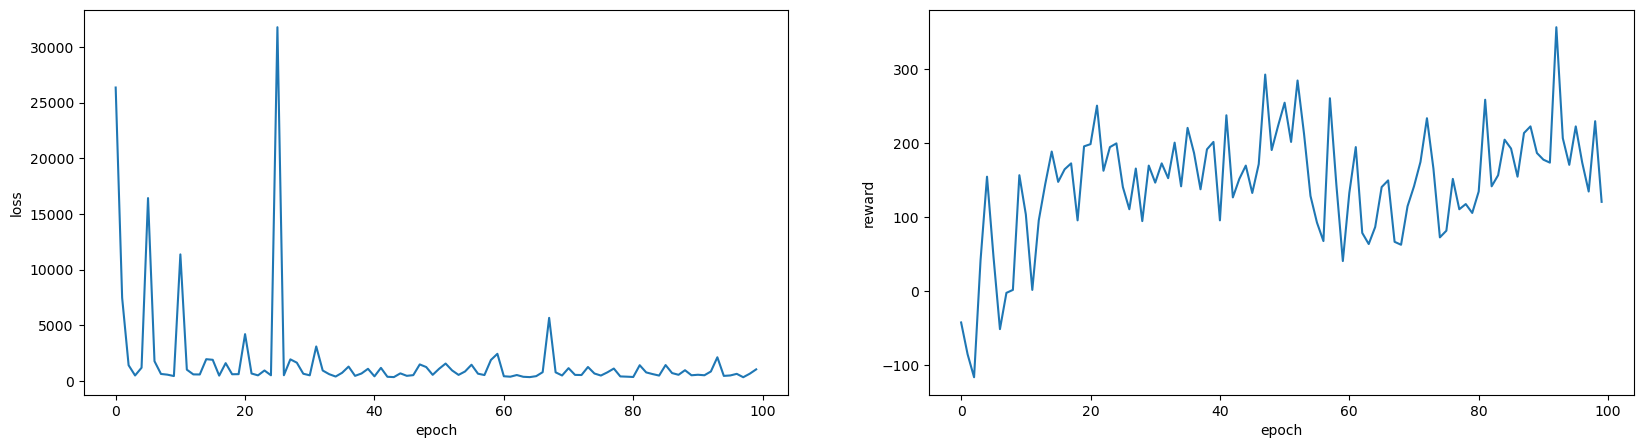

In [202]:
def plot_loss_reward(total_losses, total_rewards):
    fig = plt.figure(figsize=(20, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.plot(total_losses)
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("loss")
    ax2.plot(total_rewards)
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("reward")
    plt.show()

plot_loss_reward(total_losses, total_rewards)

In [203]:
def plot_train_test_by_q(train_env, test_env, Q, algorithm_name):

    # train
    pobs = train_env.reset()   
    train_acts = []
    train_rewards = []

    for _ in range(len(train_env.data)-1):
        pact = Q(np.array(pobs, dtype =  np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        train_acts.append(pact)

        obs, reward, done = train_env.step(pact)
        train_rewards.append(reward)

        pobs = obs


    train_profits = train_env.profits

    # test
    pobs = test_env.reset()
    test_acts = []
    test_rewards = []

    for _ in range(len(test_env.data) - 1):

        pact = Q(np.array(pobs, dtype =  np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        test_acts.append(pact)

        obs, reward, done = test_env.step(pact)
        test_rewards.append(reward)

        pobs = obs


    test_profits = test_env.profits

    #plot
    train_copy = train_env.data.copy()
    test_copy = test_env.data.copy()
    train_copy['act'] = train_acts + [np.nan]
    train_copy['reward'] = train_rewards + [np.nan]
    test_copy['act'] = test_acts + [np.nan]
    test_copy['reward'] = test_rewards + [np.nan]
    train0 = train_copy[train_copy['act'] == 0 ]
    train1 = train_copy[train_copy['act'] == 1 ]
    train2 = train_copy[train_copy['act'] == 2 ]

    test0 = test_copy[test_copy['act'] == 0 ]
    test1 = test_copy[test_copy['act'] == 1 ]
    test2 = test_copy[test_copy['act'] == 2 ]

    act_color0, act_color1, act_color2 = 'grey', 'royalblue', 'tomato'


    data = [
        Candlestick(x = train0.index, open = train0['open'], high = train0['max'], low = train0['min'], close = train0['close'], increasing = dict(line = dict(color = act_color0)), decreasing = dict(line = dict(color = act_color0))),
        Candlestick(x = train1.index, open = train1['open'], high = train1['max'], low = train1['min'], close = train1['close'], increasing = dict(line = dict(color = act_color1)), decreasing = dict(line = dict(color = act_color1))),
        Candlestick(x = train2.index, open = train2['open'], high = train2['max'], low = train2['min'], close = train2['close'], increasing = dict(line = dict(color = act_color2)), decreasing = dict(line = dict(color = act_color2))),
        Candlestick(x = test0.index, open = test0['open'], high = test0['max'], low = test0['min'], close = test0['close'], increasing = dict(line = dict(color = act_color0)), decreasing = dict(line = dict(color = act_color0))),
        Candlestick(x = test1.index, open = test1['open'], high = test1['max'], low = test1['min'], close = test1['close'], increasing = dict(line = dict(color = act_color1)), decreasing = dict(line = dict(color = act_color1))),
        Candlestick(x = test2.index, open = test2['open'], high = test2['max'], low = test2['min'], close = test2['close'], increasing = dict(line = dict(color = act_color2)), decreasing = dict(line = dict(color = act_color2))),
    
    ]
    title = '{}: train s-reward: {}, profits{}, test: {}, profits {}'.format(
        algorithm_name,
        int(sum(train_rewards)),
        int(train_profits),
        int(sum(test_rewards)),
        int(test_profits)
    )
    layout = {
        'title': title,
        'showlegend': False,
        'shapes': [
            {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0, 0, 0)', 'width': 1}},

        ],
        'annotations': [
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': 'test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data'},
        ]
    }
    figure = Figure(data = data, layout = layout)
    iplot(figure, image_width = 50, image_height = 50)

plot_train_test_by_q(Environment1(train), Environment1(test), Q, 'DQN')